<a href="https://colab.research.google.com/github/ckj18/ML.github.io/blob/main/DreamBooth_Stable_Diffusion2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-wwugz1y0
  Running command git clone --filter=blob:none --quiet https://github.com/aleju/imgaug /tmp/pip-req-build-wwugz1y0
  Resolved https://github.com/aleju/imgaug to commit 0101108d4fed06bc5056c4a03e2bcb0216dac326
  Preparing metadata (setup.py) ... done


In [2]:
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow

class Img_aug:
    def __init__(self):
        self.sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.seq = iaa.Sequential(
            [
                iaa.Fliplr(0.25),
                self.sometimes(iaa.CropAndPad(
                    percent=(-0.05, 0.1),
                    pad_mode=ia.ALL,
                    pad_cval=(0, 255)
                )),
                self.sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # x축과 y축의 크기 조절 범위
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # x축과 y축으로의 이동 범위
                    rotate=(-20, 20),  # 회전 각도 범위
                    shear=(-12, 12),  # 기울기 범위
                    order=[0, 1],  # 보간법 선택 (0: 최근접 이웃, 1: 쌍선형 보간)
                    cval=(0, 255),  # 상수 채우기 모드인 경우 사용할 상수 범위
                    mode=ia.ALL  # 변형에 사용할 모드 선택
                )),
                iaa.SomeOf((0, 5),
                           [
                               self.sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),  # 슈퍼픽셀 변환
                               iaa.OneOf([
                                   iaa.GaussianBlur((0, 3.0)),  # 가우시안 블러
                                   iaa.AverageBlur(k=(2, 7)),  # 평균 블러
                                   iaa.MedianBlur(k=(3, 11)),  # 중간값 블러
                               ]),
                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # 선명도 조절
                               iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # 엠보싱
                               iaa.SimplexNoiseAlpha(iaa.OneOf([
                                   iaa.EdgeDetect(alpha=(0.5, 1.0)),
                                   iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                               ])),
                               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.02 * 255), per_channel=0.5),  # 가우시안 노이즈
                               iaa.OneOf([
                                   iaa.Dropout((0.01, 0.05), per_channel=0.20),  # 확률적으로 픽셀 제거
                                   iaa.CoarseDropout((0.01, 0.05), size_percent=(0.01, 0.02), per_channel=0.2),
                               ]),
                               iaa.Invert(0.05, per_channel=True),  # 색상 반전
                               iaa.Add((-10, 10), per_channel=0.5),  # 밝기 조절
                               iaa.AddToHueAndSaturation((-20, 20)),  # 색조와 채도 조절
                               iaa.OneOf([
                                   iaa.Multiply((0.5, 1.5), per_channel=0.5),  # 색상 증폭
                                   iaa.FrequencyNoiseAlpha(
                                       exponent=(-4, 0),
                                       first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                       second=iaa.ContrastNormalization((0.4, 2.0))
                                   )
                               ]),
                               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.2),  # 대비 조절
                               iaa.Grayscale(alpha=(0.0, 1.0)),  # 흑백 변환
                               self.sometimes(iaa.ElasticTransformation(alpha=(0.3, 2.5), sigma=0.25)),  # 탄성 변형
                               self.sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.02))),  # 조각 모양 왜곡
                               self.sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.02)))  # 원근 변형
                           ],
                           random_order=True
                           )
            ],
            random_order=True
        )

In [9]:
import os
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import random

aug = Img_aug()
augment_num = 16

name = 'image'

img = cv2.imread('sample.jpg')

currentPath = '/content/drive/MyDrive/'
print(currentPath)
os.chdir(currentPath)

save_path = 'sample/' + name
os.makedirs(save_path, exist_ok=True)

# 생성된 이미지 출력 및 저장
generated_images = []
for i in range(augment_num):
    augmented_img = aug.seq.augment_image(img)
    generated_images.append(augmented_img)

    cv2.imwrite(save_path + '/' + name + '_{}.jpg'.format(i), augmented_img)

# Mix 처리
for i in range(4):
    row = 4  # 이미지의 행 인덱스 (추가된 행)
    col = i  # 이미지의 열 인덱스

    # 랜덤하게 이미지 선택
    random_indices = random.sample(range(augment_num), 2)
    img1 = generated_images[random_indices[0]]
    img2 = generated_images[random_indices[1]]

    # Mix 처리
    mixed_img = cv2.addWeighted(img1, 0.5, img2, 0.5, 0)
    cv2.imwrite(save_path + '/mixed_{}.jpg'.format(i), mixed_img)

/content/drive/MyDrive/


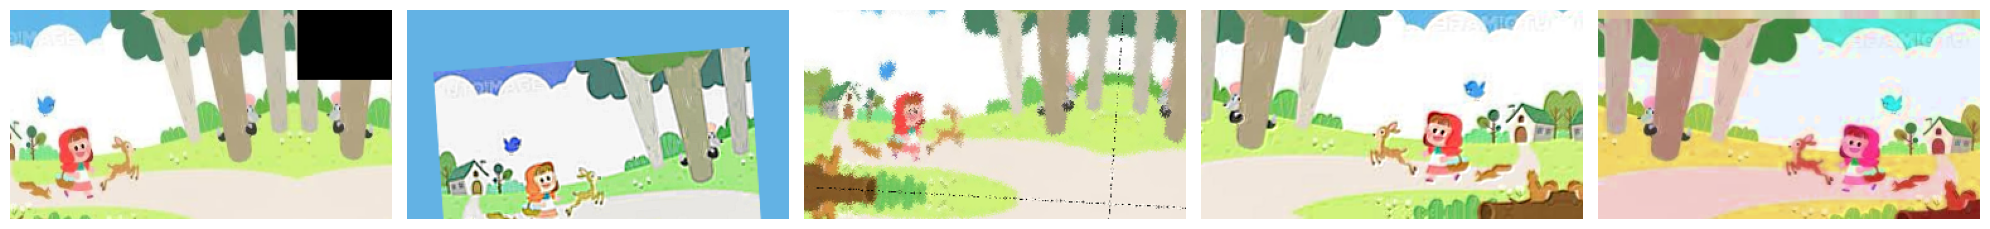

Complete augmenting images


In [10]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# 유사도 계산 및 유사도가 덜 높은 이미지 출력
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
similarities = []

for i, generated_img in enumerate(generated_images):
    generated_gray = cv2.cvtColor(generated_img, cv2.COLOR_BGR2GRAY)
    similarity = ssim(original_img, generated_gray)
    similarities.append(similarity)

# 유사도가 덜 높은 이미지의 인덱스를 가져옴
similar_indices = np.argsort(similarities)[::-1][7:12]

# 유사도가 덜 높은 이미지 출력
for i, idx in enumerate(similar_indices):
    axs[i].imshow(cv2.cvtColor(generated_images[idx], cv2.COLOR_BGR2RGB))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

print('Complete augmenting images')

# 1-click execution of Dreambooth Stable Diffusion
- Jun 8, 2023 - Updated accelerate version
- May 24, 2023 - Fixed pytorch version error, again.
- May 19. 2023 - Fixed pytorch version error
- Mar 26, 2023 - Use python3 instead of accelerate to avoid hang


Tutorials and prompts at [stable-diffusion-art.com](https://stable-diffusion-art.com)

The latest copy can be found [here](https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb).

Modified from [Shivam Shrirao](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)'s repo.

Instructions - See [acommpanying article](https://stable-diffusion-art.com/dreambooth/) for step-by-step walkthrough. Leave comment under article if you have any questions.
1. Make sure your Google Drive has at least 2GB (4GB if `fp16` is not checked)
2. Prepare you custom image to be 512x512 pixels.
1. Run the first cell by clicking the play button.
2. Grant access to Google Drive.
3. Click "Choose files" to upload your images
4. After it is complete (800 steps should take 30 mins), go to your [Google Drive](https://drive.google.com/drive/my-drive) to download your model in folder Dreambooth_model
5. Use the 2nd cell to generate new images using the new model.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tesla T4, 15360 MiB, 15101 MiB
[*] Weights will be saved at /content/stable_diffusion_weights/output
Uploading instance images for `drawing of person`


Saving image_0.jpg to image_0.jpg
Saving image_1.jpg to image_1.jpg
Saving image_2.jpg to image_2.jpg
Saving image_3.jpg to image_3.jpg
Saving image_4.jpg to image_4.jpg
Saving image_5.jpg to image_5.jpg
Saving image_6.jpg to image_6.jpg
Saving image_7.jpg to image_7.jpg
Saving image_8.jpg to image_8.jpg
Saving image_9.jpg to image_9.jpg
Saving image_10.jpg to image_10.jpg
Saving image_11.jpg to image_11.jpg
Saving image_12.jpg to image_12.jpg
Saving image_13.jpg to image_13.jpg
Saving image_14.jpg to image_14.jpg
Saving image_15.jpg to image_15.jpg
Saving mixed_0.jpg to mixed_0.jpg
Saving mixed_1.jpg to mixed_1.jpg
Saving mixed_2.jpg to mixed_2.jpg
Saving mixed_3.jpg to mixed_3.jpg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━

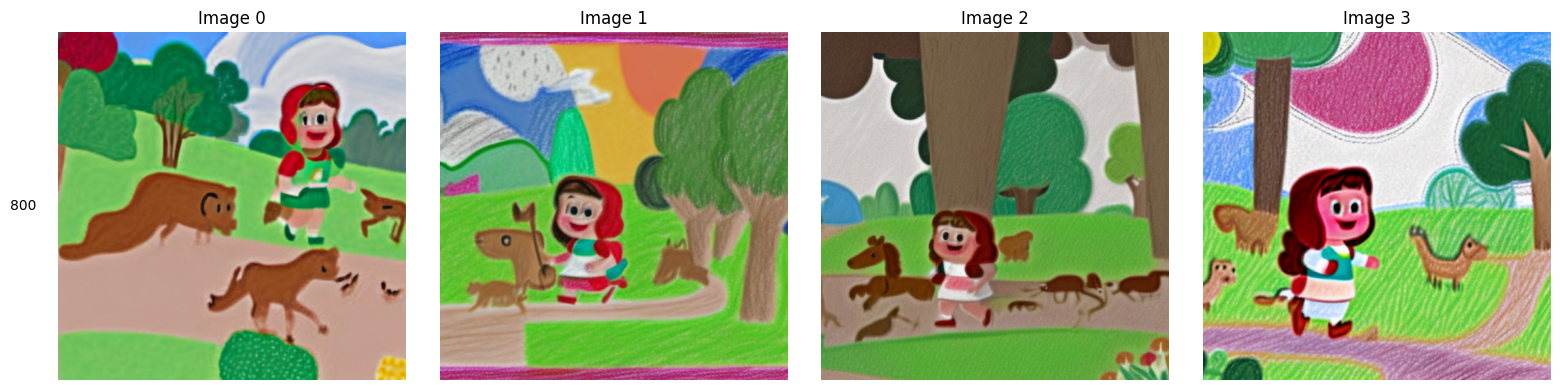

In [11]:
import time
time_start = time.time()
#@title DreamBooth
HUGGINGFACE_TOKEN = ""

#@markdown Name/Path of the initial model. (Find model name [here](https://huggingface.co/models))
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}
BRANCH = "fp16" #@param {type:"string"}

#@markdown Enter instance prompt and class prompt.\
#@markdown Example 1: photo of zwx person, photo of a person\
#@markdown Example 2: photo of zwx toy, photo of a toy
instance_prompt = "drawing of person" #@param {type:"string"}
class_prompt =  "drawing of walking forest" #@param {type:"string"}
training_steps = 800 #@param {type:"integer"}
learning_rate = 1e-6 #@param {type:"number"}

#@markdown  Convert to fp16? (takes half the space (2GB)).
fp16 = True #@param {type: "boolean"}
#@markdown  Compile xformers (Try only if you see xformers error. Will take 1 more hour).
complie_xformers = False #@param {type: "boolean"}

save_to_gdrive = True
from google.colab import drive
if save_to_gdrive:
  drive.mount('/content/drive')


#@markdown Clear log after run?
CLEAR_LOG = False #@param {type:"boolean"}


OUTPUT_DIR = "stable_diffusion_weights/output"
OUTPUT_DIR = "/content/" + OUTPUT_DIR

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR


# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
    {
        "instance_prompt":      instance_prompt,
        "class_prompt":         class_prompt,
        "instance_data_dir":    "/content/data/instance",
        "class_data_dir":       "/content/data/class"
    },
#     {
#         "instance_prompt":      "photo of ukj person",
#         "class_prompt":         "photo of a person",
#         "instance_data_dir":    "/content/data/ukj",
#         "class_data_dir":       "/content/data/person"
#     }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)


import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)


def clear():
    from IPython.display import clear_output; return clear_output()



# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install repos
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
#%pip install torch==2.0.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate==0.19.0 transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers
# install xformer wheel
print('Install xformers')
if complie_xformers:
  %pip install git+https://github.com/facebookresearch/xformers@4c06c79#egg=xformers
#else:
#  %pip install  --no-deps -q https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl
#%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/4c06c79_various6/xformers-0.0.15.dev0_4c06c79.d20221201-cp38-cp38-linux_x86_64.whl
#%pip install -q https://github.com/ShivamShrirao/xformers-wheels/releases/download/4c06c79/xformers-0.0.15.dev0+4c06c79.d20221201-cp38-cp38-linux_x86_64.whl


############## Edit this section to customize parameters
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision=$BRANCH \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps \
  --save_interval=10000 \
  --save_sample_prompt="$instance_prompt" \
  --concepts_list="concepts_list.json"

########################################

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

from natsort import natsorted
from glob import glob
import os
weightdirs = natsorted(glob(OUTPUT_DIR + os.sep + "*"))
if len(weightdirs) == 0:
  raise KeyboardInterrupt("No training weights directory found")
WEIGHTS_DIR = weightdirs[-1]


ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")


if CLEAR_LOG:
  clear()

print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')

plt.tight_layout()
plt.savefig('grid.png', dpi=72)

if save_to_gdrive:
  import os.path
  gPath = "/content/drive/MyDrive/Dreambooth_model"
  !mkdir -p $gPath
  filename = 'model.ckpt'
  i = 1
  ckpt_gpath = gPath + '/' + filename
  while os.path.isfile(ckpt_gpath):
    filename = 'model%d.ckpt'%i
    ckpt_gpath = gPath + '/' + filename
    i += 1
  ckpt_gpath = gPath + '/' + filename
  !cp $ckpt_path $ckpt_gpath
  print('Model saved to %s'%ckpt_gpath)


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.15.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as le

  0%|          | 0/30 [00:00<?, ?it/s]

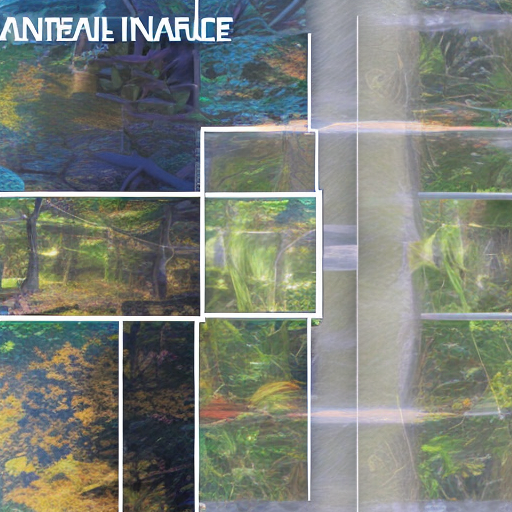

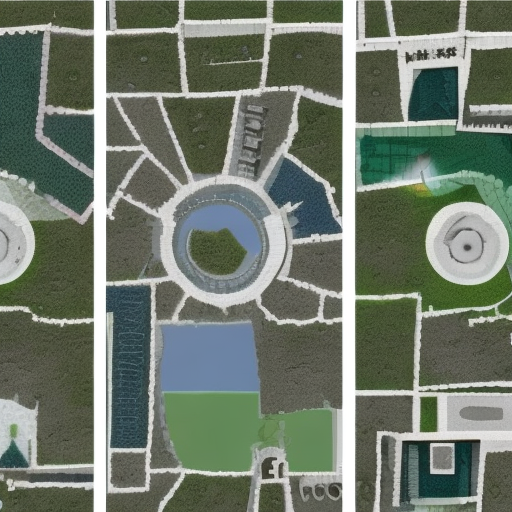

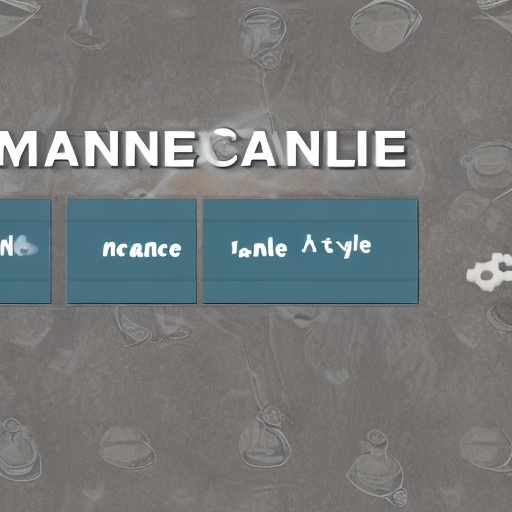

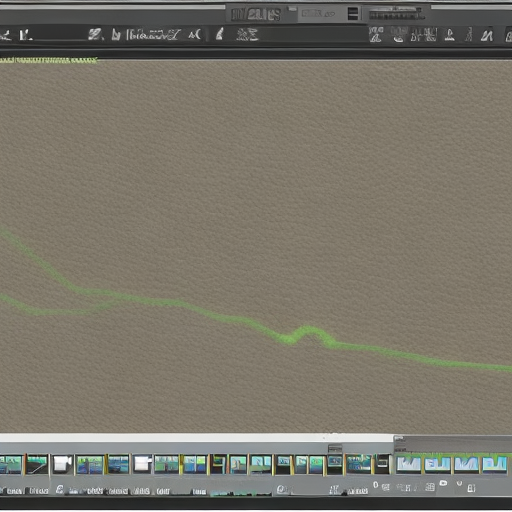

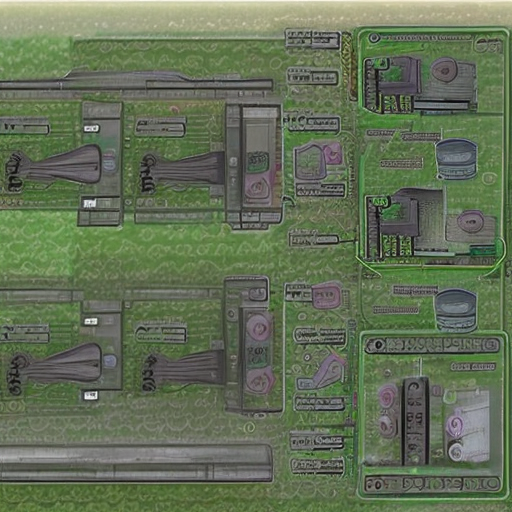

In [12]:
#@title Test image generation from model

prompt = "maintain style of instance image" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 5 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 30 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = 100 #@param {type:"number"}


import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive
if 'pipe' not in locals():
  scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
  pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)


with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [14]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of zwx dog in a bucket")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.


In [ ]:
#@title (Optional) Delete diffuser and old weights and only keep the ckpt to free up drive space.

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
import os
for f in glob(OUTPUT_DIR+os.sep+"*"):
    if f != WEIGHTS_DIR:
        shutil.rmtree(f)
        print("Deleted", f)
for f in glob(WEIGHTS_DIR+"/*"):
    if not f.endswith(".ckpt") or not f.endswith(".json"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)

# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |
